# Random Forest

After reading (Liu, V. et al.) and (Mahmoud, M. et al.) I decided to begin expirementing with random forest models instead of logistic regression models.

This means I will not be using the engineered interaction terms, but these models will be able to help anaylze the base features with *feature importance*

## Read and prep data for modeling

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [38]:
df = pd.read_csv('../data/frame_no_interactions.csv', index_col=0)
df.head()


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,diag1_group_diabetes,diag1_group_digestive,...,glucose_group_normal,admit_type_group_elective,admit_type_group_na,admit_type_group_urgent,diabetesMed_flag,change_flag,metformin_flag,insulin_flag,num_drugs,target
0,1,41,0,1,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
1,3,59,0,18,0,0,0,9,0,0,...,0,0,0,0,1,1,0,1,1,0
2,2,11,5,13,2,0,1,6,0,0,...,0,0,0,0,1,0,0,0,1,0
3,2,44,1,16,0,0,0,7,0,0,...,0,0,0,0,1,1,0,1,1,0
4,1,51,0,8,0,0,0,5,0,0,...,0,0,0,0,1,1,0,1,2,0


In [39]:
# split inital train and test sections

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.2, stratify=df['target'])

In [40]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler


cv = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
    )

scaler = StandardScaler()

smote = SMOTE(random_state=42)
under_sample = RandomUnderSampler(random_state=42)
rf = RandomForestClassifier(random_state=42)

pipe = Pipeline([
    ('scaler', scaler),
   # ('smote', smote),
   ('under_sample', under_sample),
    ('model', rf)
])

scores = cross_val_score(
    pipe, 
    X_train, 
    y_train, 
    cv = cv,
    scoring=make_scorer(roc_auc_score) 
    )

print('roc_auc score per fold: ', scores)
print('mean roc_auc score: ', scores.mean())

roc_auc score per fold:  [0.58379022 0.60385437 0.57031098 0.59686148 0.60366951 0.61518374
 0.58515202 0.60390601 0.58540534 0.59521847]
mean roc_auc score:  0.5943352122042651


The first run of random forest scores were abysmally poor running SMOTE:
 - mean roc_auc score:  0.5033108087188244

Swapping to RandomUnderSampler was somewhat better:
- mean roc_auc score:  0.5962262523855333

In [61]:
# shared code
import matplotlib.pyplot as plt


def make_rf_pipe():
    _s = StandardScaler()
    _u = RandomUnderSampler(random_state=42)
    _rf = RandomForestClassifier(random_state=42)
    return Pipeline(
        [
            ('scaler', _s),
            ('under_sample', _u),
            ('model', _rf)
        ]
    )

def check_feature_importances(pipe: Pipeline, feat_names: np.ndarray):
    importances = pipe.steps[2][1].feature_importances_

    feat_imp = pd.DataFrame({
        'feature': feat_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print(feat_imp.head(15))

    plot_feature_importance(feat_imp, 'feature', 'importance', 15)


def plot_feature_importance(df, col1, col2, size):
    plt.figure(figsize=(10,6))
    plt.barh(df[col1][:size][::-1], df[col2][:size][::-1])
    plt.title("Top 15 Feature Importances (Random Forest)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()



### Feature Importance Using Random Forest Classifier

                    feature  importance
1        num_lab_procedures    0.104183
3           num_medications    0.092272
0          time_in_hospital    0.067717
6          number_inpatient    0.054397
7          number_diagnoses    0.046249
2            num_procedures    0.046101
58                num_drugs    0.029448
4         number_outpatient    0.023286
46            gender_female    0.021512
5          number_emergency    0.018423
36      discharge_loc_other    0.017782
45            age_group_>60    0.017740
16  diag2_group_circulatory    0.016610
32        diag3_group_other    0.016513
25  diag3_group_circulatory    0.016415


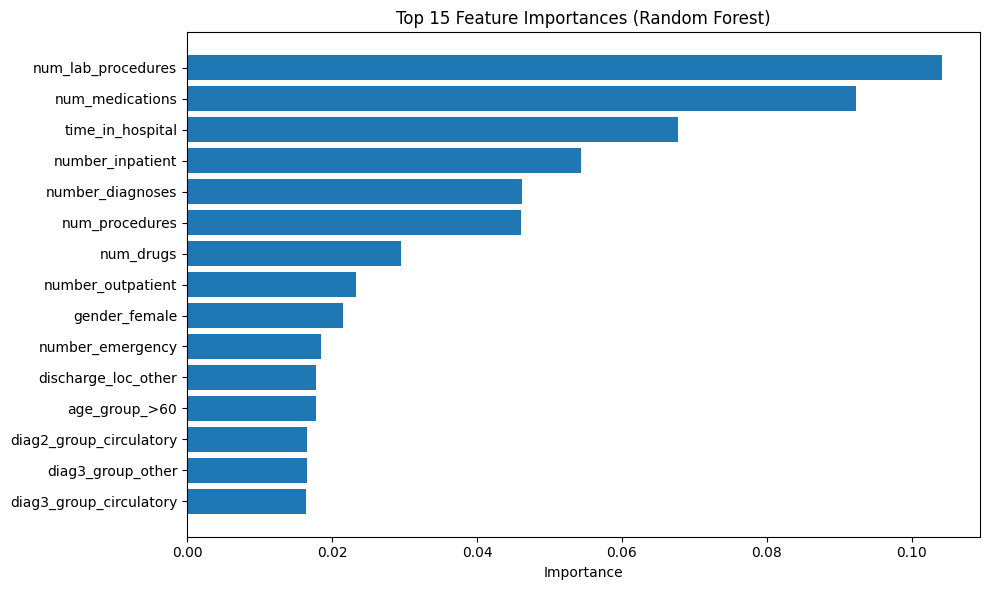

In [62]:



X_train_0, X_validate, y_train_0, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

pipe_rf_0 = make_rf_pipe()

pipe_rf_0.fit(X_train_0, y_train_0)

check_feature_importances(pipe_rf_0, feat_names=X_train_0.columns)


### Permutation Importance of Features

In [63]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    pipe_rf_0, 
    X_validate, 
    y_validate, 
    scoring='roc_auc', 
    n_repeats=10, 
    n_jobs=-1, 
    random_state=42
    )

perm_df = (pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': r.importances_mean, #type: ignore
    'importance_std': r.importances_std #type: ignore
})
 .sort_values('importance_mean', ascending=False))

print(perm_df.head(15))



                        feature  importance_mean  importance_std
6              number_inpatient         0.064953        0.003673
36          discharge_loc_other         0.023462        0.003044
0              time_in_hospital         0.006889        0.003085
2                num_procedures         0.006080        0.001522
3               num_medications         0.006012        0.002197
5              number_emergency         0.005663        0.001527
7              number_diagnoses         0.005015        0.002978
1            num_lab_procedures         0.004590        0.001710
46                gender_female         0.002452        0.001013
24      diag2_group_respiratory         0.001629        0.000739
43               race_cat_other         0.001586        0.000560
15      diag1_group_respiratory         0.001509        0.001207
37     specialty_cat_cardiology         0.001475        0.000738
48             a1c_group_normal         0.001372        0.000568
12  diag1_group_musculosk

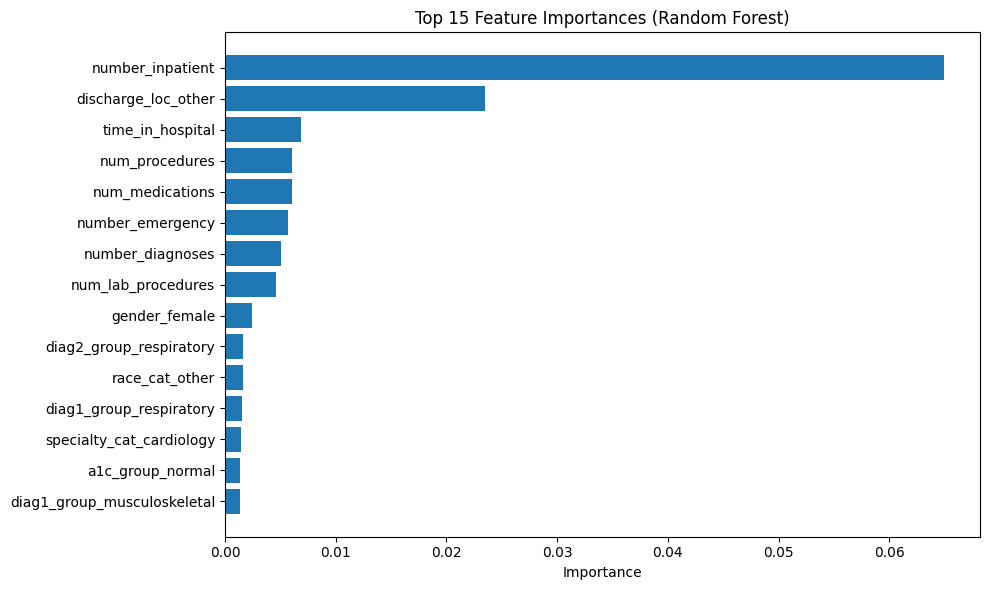

In [64]:
plt.figure(figsize=(10,6))
plt.barh(perm_df['feature'][:15][::-1], perm_df['importance_mean'][:15][::-1])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

Permutation importance reveals that the model is heavily leaning on the number of inpatient procedures for its predictions.


### Comparison of feature importance with different data sets

The above section shows feature importance plots for the data set without interaction terms

In [67]:
# get data with the interaction terms (linear data set)

df_int = pd.read_csv('../data/linear_frame.csv', index_col=0)

X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(df_int.drop(columns=['target']), df['target'], stratify=df['target'], random_state=42)

X_train_1, X_validate_1, y_train_1, y_validate_1 = train_test_split(X_train_int, y_train_int, random_state=42, stratify=y_train_int)





                              feature  importance
1                  num_lab_procedures    0.082689
3                     num_medications    0.072341
6                    number_inpatient    0.047781
0                    time_in_hospital    0.044115
7                    number_diagnoses    0.038238
2                      num_procedures    0.037413
72  discharge_loc_discharge_loc_other    0.026265
58                          num_drugs    0.026084
4                   number_outpatient    0.019358
46                      gender_female    0.018879
65        hosp_time_diag1_group_other    0.017717
5                    number_emergency    0.015744
16            diag2_group_circulatory    0.014785
32                  diag3_group_other    0.014579
25            diag3_group_circulatory    0.014423


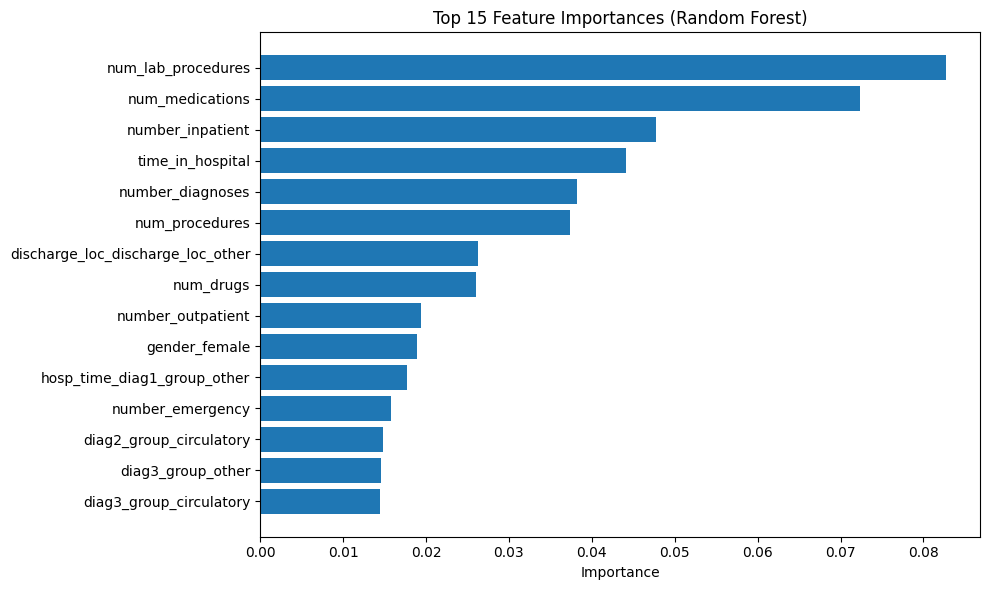

In [68]:

pipe_rf_1 = make_rf_pipe()

pipe_rf_1.fit(X_train_1, y_train_1)

check_feature_importances(pipe_rf_1, feat_names=X_train_1.columns)